# Building Queries from FactTable

In [316]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sqlalchemy

## Fetching Data from db

In [2]:
# change dbname, user, password, host, port to your own if you want to run it on your own database
def create_conn():
    connection = psycopg2.connect(dbname="4142_Database", user="postgres",
        password=os.getenv("DB_PASS"), host="localhost", port="5432")
    return connection

def get_engine(connection):
    return sqlalchemy.create_engine(f"postgresql+psycopg2://{connection.info.user}:{connection.info.password}@{connection.info.host}:{connection.info.port}/{connection.info.dbname}")

def run_sql(query):
    connection = create_conn()
    with get_engine(connection).connect() as eng:
        dataframe = pd.read_sql(sql=sqlalchemy.text(query), con=eng)
    connection.close()
    return dataframe

In [3]:
query = """
select
    *
from facttable ft
limit 10
;
"""

# df_q = run_sql(query)

## Fetching Data from csv

In [4]:
df = pd.read_csv("factTable_big.csv")
df.head(3)

,province,yearmo,month_alpha,year,total_price_index,house_price_index,land_price_index,region_mean_temp,region_max_temp,region_min_temp,region_mean_precip,region_mean_snow,mean_snow_grnd_last_day
0,NL,201201,January,2012,96.5,97.0,94.7,-6.821538,5.829231,-18.869231,105.583019,89.015625,50.148148
1,NL,202302,February,2023,106.2,108.8,102.4,-11.223404,4.187234,-24.517021,69.771429,71.333333,28.800000
2,NL,202301,January,2023,106.2,108.8,102.4,-5.344681,7.212766,-17.770213,125.956757,57.855556,15.173913


## 8 Queries
- 2 Drill down and Roll up
- 2 Slice
- 2 Dice
- 2 Combinations

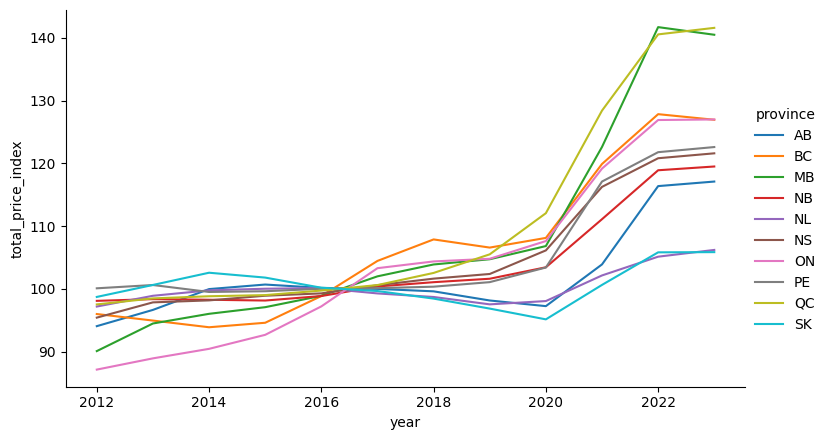

In [118]:
# Drill Down Operation: *(After merging all dimensions) 
#  Grouped  Data by "Province and Year, aggregating total_price_index by taking the average."

df1 = df.groupby(["province", "year"]).agg({'total_price_index':"mean"}).reset_index()

sns.relplot(
        data=df1,
        x="year", y="total_price_index", hue="province",
        kind="line", height=4.5, aspect=1.70
           );

In [6]:
# Roll Up Operation: Mean Precipitation by Province
query = """
select
    avg(ct.region_mean_precip) as annual_precip,
    lt.province
from regional_weather_summary ct
join location_dimension lt on lt.location_key = ct.location_key
group by lt.province
order by annual_precip desc
;
"""

df_precip = run_sql(query)
df_precip

,annual_precip,province
0,101.981583,NS
1,93.961592,NB
2,92.356042,BC
3,90.773522,NL
4,85.271865,PE
5,75.320068,QC
6,66.052238,ON
7,38.780501,MB
8,30.724801,SK
9,29.312959,AB


In [43]:
# Slice Operation: Selecting data where the location (province) is Ontario.
df_on = df[df.province == 'ON']
df_on

,province,yearmo,month_alpha,year,total_price_index,house_price_index,land_price_index,region_mean_temp,region_max_temp,region_min_temp,region_mean_precip,region_mean_snow,mean_snow_grnd_last_day
670,ON,201201,January,2012,85.5,82.6,91.8,-6.155294,6.700000,-23.717544,65.853631,43.668421,20.901408
671,ON,202302,February,2023,126.8,130.3,120.4,-7.747799,9.187421,-29.256875,45.620530,26.418519,29.886792
672,ON,202301,January,2023,127.2,130.9,120.5,-6.300000,3.889634,-22.860000,51.263399,41.280357,31.151786
673,ON,202212,December,2022,127.3,131.0,120.5,-5.328144,6.999401,-20.186826,62.236306,44.194828,16.932584
674,ON,202211,November,2022,127.3,131.1,120.5,1.675000,19.927381,-13.424405,56.455414,23.482759,5.193182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,ON,201206,June,2012,87.2,84.7,92.7,18.436047,31.738150,5.772093,77.944318,0.000000,0.000000
800,ON,201205,May,2012,86.9,84.3,92.4,13.865896,30.120231,0.178161,57.298870,0.192727,0.100000
801,ON,201204,April,2012,86.5,83.8,92.1,5.008235,21.716471,-6.694737,41.370166,5.068376,0.161290
802,ON,201203,March,2012,86.3,83.5,92.1,3.932164,24.472515,-18.600581,46.492818,11.006897,0.983186


In [32]:
# Slice Operation: Selecting Data from the time February 2023 (202302)
df_present = df[df.yearmo == 202302]
df_present

,province,yearmo,month_alpha,year,total_price_index,house_price_index,land_price_index,region_mean_temp,region_max_temp,region_min_temp,region_mean_precip,region_mean_snow,mean_snow_grnd_last_day
1,NL,202302,February,2023,106.2,108.8,102.4,-11.223404,4.187234,-24.517021,69.771429,71.333333,28.800000
135,PE,202302,February,2023,122.6,127.0,104.5,-7.387500,9.062500,-25.975000,42.728571,28.700000,3.800000
269,NS,202302,February,2023,121.6,127.0,103.5,-4.528000,10.874000,-23.634000,62.627778,37.114286,11.962963
535,NB,202302,February,2023,119.5,121.1,102.5,-8.780000,10.304000,-29.024000,41.972000,38.466667,35.380952
669,QC,202302,February,2023,141.5,149.4,120.2,-14.924812,4.743333,-33.158571,46.943210,45.321519,47.409091
671,ON,202302,February,2023,126.8,130.3,120.4,-7.747799,9.187421,-29.256875,45.620530,26.418519,29.886792
805,MB,202302,February,2023,140.6,154.2,110.8,-16.884375,0.943750,-36.062500,10.741538,15.985714,31.277778
1071,SK,202302,February,2023,105.5,111.1,96.8,-13.655263,3.306579,-35.076316,9.206944,12.952941,25.517241
1073,AB,202302,February,2023,116.9,122.2,105.1,-8.925306,6.755510,-33.985366,10.002553,15.521053,19.820896
1339,BC,202302,February,2023,126.8,126.4,119.8,0.436893,8.833981,-14.163107,115.142408,30.741584,28.930233


<AxesSubplot: xlabel='month_alpha'>

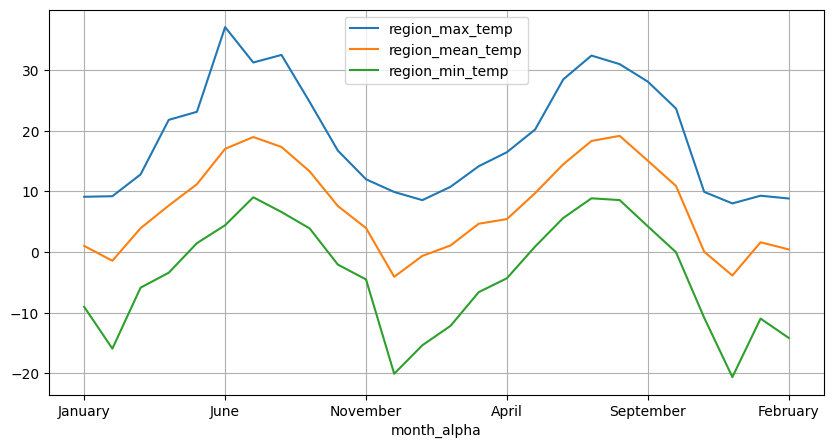

In [102]:
# Dice Operation: Selection rows where the location is BC and Year is after 2021
query = """
select
    lt.province, 
    dt.yearmo,
    dt.month_alpha,
    ct.region_mean_temp,
    ct.region_max_temp,
    ct.region_min_temp
from facttable ft
join location_dimension lt on lt.location_key = ft.location_key
join date_dimension dt on dt.date_key = ft.date_key
join regional_weather_summary ct on ct.region_summ_key = ft.region_summ_key
where lt.province = 'BC'
and dt.year >= 2021
;
"""

df_dice = run_sql(query)
df_dice.head()

df_dice.plot(x="month_alpha", y=["region_max_temp", "region_mean_temp", "region_min_temp"], figsize=(10,5), grid=True)

In [111]:
df_dice2.plot?

Signature:      df_dice2.plot(*args, **kwargs)
Type:           PlotAccessor
String form:    <pandas.plotting._core.PlotAccessor object at 0x000002231A25AD30>
File:           c:\users\jonat\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_core.py
Docstring:     
Make plots of Series or DataFrame.

Uses the backend specified by the
option ``plotting.backend``. By default, matplotlib is used.

Parameters
----------
data : Series or DataFrame
    The object for which the method is called.
x : label or position, default None
    Only used if data is a DataFrame.
y : label, position or list of label, positions, default None
    Allows plotting of one column versus another. Only used if data is a
    DataFrame.
kind : str
    The kind of plot to produce:

    - 'line' : line plot (default)
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    - 'density' : same

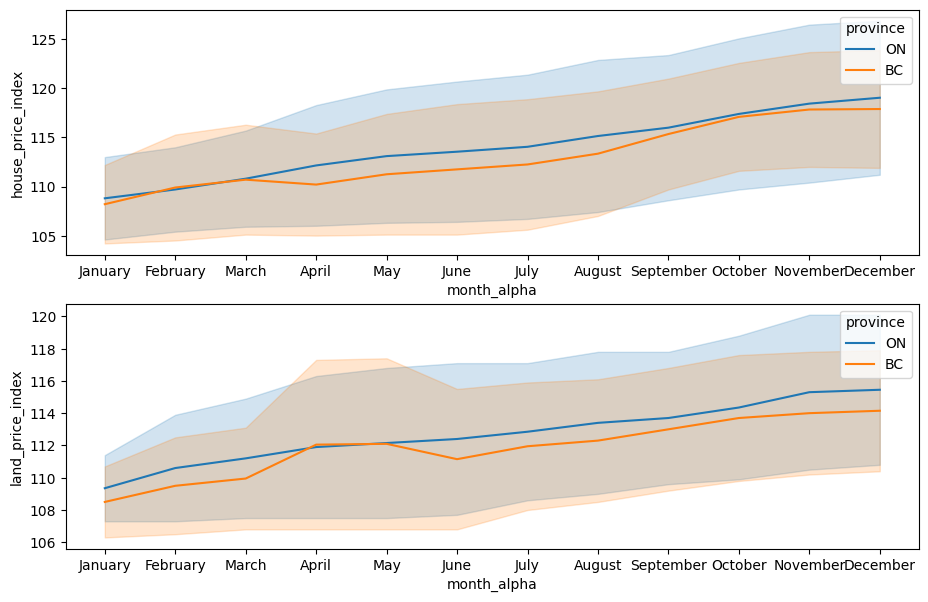

In [71]:
# Dice Operation: Select Rows where yearmonth is between 202001 and 202006 and location is BC or ON
query = """
select
    lt.province, 
    dt.yearmo,
    dt.month_alpha,
    rt.total_price_index,
    rt.house_price_index,
    rt.land_price_index
from facttable ft
join location_dimension lt on lt.location_key = ft.location_key
join date_dimension dt on dt.date_key = ft.date_key
join real_estate_dimension rt on rt.real_estate_key = ft.real_estate_key
where lt.province in ('BC', 'ON')
and dt.yearmo between 202001 and 202112
;
"""

df_dice2 = run_sql(query)

f, ax = plt.subplots(nrows=2, ncols=1, figsize = (11,7))
g = sns.lineplot(data=df_dice2, 
            x="month_alpha", y="house_price_index", hue="province", ax=ax[0]
           );
g = sns.lineplot(data=df_dice2, 
            x="month_alpha", y="land_price_index", hue="province", ax=ax[1]
           );


C:\Users\jonat\AppData\Local\Temp\ipykernel_17924\3039685759.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{i:.2f}%" for i in ax.get_yticks()]);


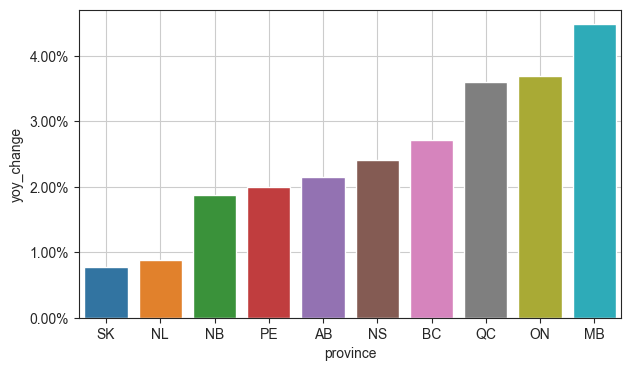

In [247]:
# Combining OLAP operations: Gettin Mean year over year change in price index, by province
d = df[['province', 'year', 'month_alpha', 'yearmo', 'total_price_index', 'house_price_index', 'land_price_index',
       'region_mean_temp']].copy()

d = d.groupby(["province", "year"]).min("yearmo")
d["yoy_change"] = d.groupby("province")[["total_price_index"]].pct_change() * 100

d_prov = d.groupby("province").mean().sort_values("yoy_change").reset_index()
d_prov


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
# ax.ticklabel_format(style='plain', axis='y')
sns.set_style(style='ticks')
sns.barplot(data=d_prov, x='province', y="yoy_change", ax=ax);
ax.set_yticklabels([f"{i:.2f}%" for i in ax.get_yticks()]);
plt.grid()

In [295]:
# Combining OLAP operations, Slice get last years (2022 Data), see month over month price change, and weather
query = """
select
    lt.province, 
    dt.yearmo,
    dt.month_alpha,
    rt.total_price_index,
    ct.region_mean_temp
from facttable ft
join location_dimension lt on lt.location_key = ft.location_key
join date_dimension dt on dt.date_key = ft.date_key
join real_estate_dimension rt on rt.real_estate_key = ft.real_estate_key
join regional_weather_summary ct on ct.region_summ_key = ft.region_summ_key
where dt.year = 2022
order by province, yearmo
;
"""

df_comb = run_sql(query)
# df_comb = df


df_comb["month_change"] = df_comb.groupby("province")["total_price_index"].pct_change() * 100

c:\users\jonat\appdata\local\programs\python\python38\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\users\jonat\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


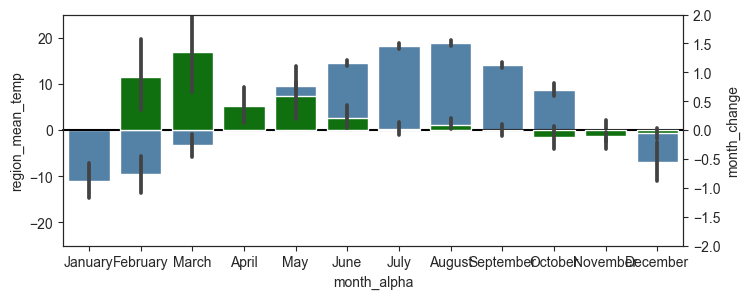

In [ ]:
# df_comb_o = df_comb.loc[df_comb.province == "MB"]

f, ax = plt.subplots(figsize=(8, 3))
sns.barplot(data=df_comb, x="month_alpha", y="region_mean_temp", color="steelblue", ax=ax)

ax.set_ylim(bottom=-25, top=25)
ax.axhline(0, color="k", clip_on=False)
# ax.set_ylabel("Diverging");
ax2 = ax.twinx()

# ax2.set_yticklabels(np.round(ax.get_yticks()/1,3));
# ax2.set_ylabel('A and B');
sns.barplot(data=df_comb, x="month_alpha", y="month_change", color="green", ax=ax2)
ax2.set_ylim(bottom=-2, top=2);

In [416]:
# Windowing Query: Coldest month for each province, and change in housing price for that month
query = """
select
    lt.province, 
    dt.yearmo, 
    dt.year,
    dt.month_alpha,
    ct.region_min_temp,
    rt.total_price_index
from facttable ft
join location_dimension lt on lt.location_key = ft.location_key
join date_dimension dt on dt.date_key = ft.date_key
join real_estate_dimension rt on rt.real_estate_key = ft.real_estate_key
join regional_weather_summary ct on ct.region_summ_key = ft.region_summ_key
where ct.region_min_temp in (
    select 
        min(ct.region_min_temp)
    from regional_weather_summary ct
        group by ct.location_key
)
"""

cold_month = run_sql(query)
# df_comb = df


# df_comb["month_change"] = df_comb.groupby("province")["total_price_index"].pct_change() * 100


In [417]:
cold_month

,province,yearmo,year,month_alpha,region_min_temp,total_price_index
0,NL,202302,2023,February,-24.517021,106.2
1,PE,202302,2023,February,-25.975000,122.6
2,NS,202302,2023,February,-23.634000,121.6
3,NB,201401,2014,January,-30.044444,98.4
4,QC,201401,2014,January,-34.577169,98.8
5,ON,201502,2015,February,-32.068293,91.4
6,MB,201901,2019,January,-41.204545,104.5
7,SK,201902,2019,February,-40.315663,97.6
8,AB,202102,2021,February,-38.910400,98.8
9,BC,202212,2022,December,-20.621429,127.6


In [426]:
# Iceberg Query: Top 5 Provinces, and times, by current price index
query = """
select
    lt.province, 
    dt.yearmo, 
    dt.year,
    dt.month_alpha,
    ct.region_min_temp,
    rt.total_price_index
from facttable ft
join location_dimension lt on lt.location_key = ft.location_key
join date_dimension dt on dt.date_key = ft.date_key
join real_estate_dimension rt on rt.real_estate_key = ft.real_estate_key
join regional_weather_summary ct on ct.region_summ_key = ft.region_summ_key
where dt.yearmo = 202302
order by rt.total_price_index desc
limit 5
"""

df_ice = run_sql(query)

In [427]:
df_ice

,province,yearmo,year,month_alpha,region_min_temp,total_price_index
0,QC,202302,2023,February,-33.158571,141.5
1,MB,202302,2023,February,-36.062500,140.6
2,ON,202302,2023,February,-29.256875,126.8
3,BC,202302,2023,February,-14.163107,126.8
4,PE,202302,2023,February,-25.975000,122.6
